<a href="https://colab.research.google.com/github/Wxyxixixi/comp5329/blob/kaiming-initialization/MLP_5329_graph_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import h5py
import pandas as pd
import numpy as np
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

#download files from google drive
download = drive.CreateFile({'id':'1fGT2vvmDcGJkh_Z2QZ-9DqCs_zNXgAU0'})
download.GetContentFile('train_128.h5')
download = drive.CreateFile({'id':'1T5dR0YruZ9yGOiEkq-Dj0Xj6PzdnRJSw'})
download.GetContentFile('train_label.h5')
download = drive.CreateFile({'id':'1X-xKBwhtWu17e7rrro1esNtsbGgmsUlr'})
download.GetContentFile('test_128.h5')

#read files
train_data = h5py.File('train_128.h5','r')
label_data = h5py.File('train_label.h5','r')
test_data = h5py.File('test_128.h5','r')

#get raw data
input_data = train_data['data'][:]  # training data 
output_data = label_data['label'][:] # training data label
test_data = test_data['data'][:] # testing data

In [0]:
test_data

array([[-1488.66464507,   653.26252699,  -269.6704255 , ...,
           41.85469634,    29.75681331,    -8.43981959],
       [ 1871.88876409,  1077.02333858,   768.27447504, ...,
           12.80051648,   -42.35655962,    36.66053284],
       [  385.96046756, -1535.62583473,  -448.46663912, ...,
          -39.01204158,     7.55727077,     9.05490692],
       ...,
       [ -510.60945635,  -726.94527121,  -207.56729926, ...,
           21.49458526,    -3.24460034,   129.99005597],
       [ -220.99035211, -1412.48240142,  -442.77091031, ...,
          -14.44252252,    66.93052758,    46.78397311],
       [-1521.14047237,    92.54090804,   265.69559511, ...,
           -8.9647171 ,    41.84234159,   -59.93616383]])

In [0]:
class Activation(object):
    def __tanh(self, x):
        return np.tanh(x)

    def __tanh_deriv(self, a):
        # a = np.tanh(x)   
        return 1.0 - a**2

    def __logistic(self, x):
        return (1.0 / (1.0 + np.exp(-x)))

    def __logistic_deriv(self, a):
        # a = logistic(x) 
        return  (a * (1 - a ))

    def __ReLU(self,x):
        return x * (x > 0)
    
    def __ReLU_deriv(self,a):
        return 1 * (a > 0)    

    def __softmax(self, x):
        y = np.atleast_2d(x)
        y = np.exp(y - np.expand_dims(np.max(y, -1),-1))
        sum_va = np.expand_dims(np.sum(y,-1), -1)  
        return y / sum_va

    def __softmax_deriv(self, a):
        return a * (1 - a)
    
    def __init__(self,activation='tanh'):
        if activation == 'logistic':
            self.f = self.__logistic
            self.f_deriv = self.__logistic_deriv
        elif activation == 'tanh':
            self.f = self.__tanh
            self.f_deriv = self.__tanh_deriv
        elif activation == 'softmax':
            self.f = self.__softmax
            self.f_deriv = self.__softmax_deriv
        elif activation == 'ReLU':
            self.f = self.__ReLU
            self.f_deriv = self.__ReLU_deriv

In [0]:
class HiddenLayer(object):    
    def __init__(self,n_in, n_out,
                 activation_last_layer='tanh',activation='tanh', dropout=None, W=None, b=None):

        self.input=None
        self.activation=Activation(activation).f
        self.dropout=dropout
        self.dropout_vector = None
        
        # activation deriv of last layer
        self.activation_deriv=None
        if activation_last_layer:
            self.activation_deriv=Activation(activation_last_layer).f_deriv

        self.W = np.random.uniform(
                low=-np.sqrt(6. / (n_in + n_out)),
                high=np.sqrt(6. / (n_in + n_out)),
                size=(n_in, n_out))
        if activation == 'logistic':
            self.W *= 4

        self.b = np.zeros(n_out,)
        
        self.grad_W = np.zeros(self.W.shape)
        self.grad_b = np.zeros(self.b.shape)
        
        self.vel_W = np.zeros(self.W.shape)
        self.vel_b = np.zeros(self.b.shape)
        
    def forward(self, input):

            # Calculate linear output
        lin_output = np.dot(input, self.W) + self.b
            
        self.output = (
                lin_output if self.activation is None
                else self.activation(lin_output))    
        if self.dropout:
            self.dropout_vector = np.random.binomial(1, 1-self.dropout, size=self.output.shape[-1])/(1-self.dropout)
            self.output = self.output * self.dropout_vector
        self.input=input

        return self.output
    
    def backward(self, delta, output_layer=False):
        
        self.grad_W = np.atleast_2d(self.input).T.dot(np.atleast_2d(delta))
        
        if self.dropout: 
          self.dropout_vector*self.grad_W  
        self.grad_b = np.sum(delta,axis=0)
        if self.activation_deriv: 
          delta = delta.dot(self.W.T) * self.activation_deriv(self.input)
            
        return delta

In [0]:
class MLP:
    def __init__(self, layers, activation, dropout, learning_rate, batch_size, momentum, weight_decay ,epochs, test_size):
       
        ### initialize layers
        self.layers=[]
        self.params=[]
        self.activation = activation
        self.dropout = dropout
        self.lr = learning_rate
        self.batch_size = batch_size
        self.momentum = momentum
        self.weight_decay = weight_decay
        self.epochs = epochs
        self.test_size = test_size
        
        for i in range(len(layers)-1):
            self.layers.append(HiddenLayer(layers[i],layers[i+1],activation[i],activation[i+1],self.dropout[i]))

    def normlization(self, x):
      mean = np.mean(x, axis = 0)
      stand_devi = np.std(x-mean, axis = 0)
      return (x - mean) / stand_devi

    def forward(self,input):
        for layer in self.layers:
            output=layer.forward(input=input)
            input=output
        return output
    
    def criterion_CELoss(self,y,y_hat):
        error = y * np.log(y_hat)
        loss = -np.sum(error)
        #delta = y_hat-y
        delta = -(y-y_hat) * self.layers[-1].activation_deriv(y_hat)
        return loss,delta
        
    def backward(self,delta):
        delta=self.layers[-1].backward(delta,output_layer=True)
        for layer in reversed(self.layers[:-1]):
            delta=layer.backward(delta)
            
    def update(self,lr):

        for layer in self.layers:
          layer.vel_W = layer.vel_W * self.momentum + layer.grad_W * self.lr
          layer.vel_b = layer.vel_b * self.momentum + layer.grad_b * self.lr
          layer.W -= (layer.vel_W + layer.W * self.weight_decay)
          layer.b -= (layer.vel_b + layer.b * self.weight_decay)

            
    def generate_batches(self,X, y, batch_size):
        rand = np.random.choice(len(y), len(y), replace=False)
        X_shuffled = X[rand]
        y_shuffled = np.array(y)[rand.astype(int)]
        batches = [(X_shuffled[i:i+self.batch_size,:], y_shuffled[i:i+self.batch_size]) for i in range(0, len(y), self.batch_size)]
        return batches

    def predict(self, x):
        x = np.array(x)
        yhat = self.forward(x)
        yhat = np.argmax(yhat,axis=1)
        return yhat

    def fit(self, X, y):
     
        y_dummies = np.array(pd.get_dummies(y))
        X_train, X_val, y_train, y_val = train_test_split(X, y_dummies, test_size = self.test_size)
        
        # normalise the data
        #X_train = self.normlization(X_train)
        #X_val = self.normlization(X_val)

        to_return = np.zeros(self.epochs)
        acc_validation = []
        acc_training = []
        logloss = []

        batches = self.generate_batches(X_train, y_train, self.batch_size)
        for k in range(self.epochs):
            sum_loss = 0

            yhat_train = self.forward(X_train)
            yhat_val = self.forward(X_val)
            
            # get max value for train and validation
            y_train_max = np.argmax(np.array(y_train),axis=1)
            yhat_train_max = np.argmax(yhat_train,axis=1)

            y_val_max = np.argmax(np.array(y_val),axis=1)
            yhat_val_max = np.argmax(yhat_val,axis=1)

            # Calculate train and Test Accuracy
            accuracy_train = (np.sum(y_train_max == yhat_train_max)) / (y_train.shape[0])
            accuracy_val = (np.sum(y_val_max == yhat_val_max)) / (y_val.shape[0])
            # 

            for X_batch,y_dummies in batches:
                # forward pass
                y_hat = self.forward(X_batch)
                    
                # backward pass
                loss,delta=self.criterion_CELoss(y_dummies,y_hat)

                sum_loss += loss
                self.backward(delta)
                    
                # update
                self.update(self.lr)
            to_return[k] = sum_loss/X_train.shape[0]

            acc_validation.append(accuracy_train)
            acc_training.append(accuracy_val)
            logloss.append(to_return[k])
            
            if k % 10 == 9:
                print('Epoch: %d, train Accuracy: %.4f, Val Accuracy: %.4f, Loss: %.4f'
                    %(k+1, accuracy_train, accuracy_val, to_return[k]))
       #         print(acc_validation)
        return acc_training, acc_validation, logloss

In [0]:
def train_test_split(X, y, test_size=0.25):
    X=np.array(X)
    y=np.array(y)
    idxs = np.arange(X.shape[0])
    np.random.shuffle(idxs)
    train_idxs = idxs[0:round(((1-test_size)*X.shape[0]))]

    X_train = X[train_idxs]
    y_train = y[train_idxs]
    X_test =  X[~train_idxs]
    y_test = y[~train_idxs]

    return X_train, X_test, y_train, y_test

In [0]:

layers = [128, 128, 128, 10]
activation = [None, 'ReLU', 'ReLU', 'softmax']
dropout = [0.1, 0.1, 0.0, 0.0]
learning_rate=0.0001 
batch_size=32
momentum=0.9
weight_decay=0.00001
epochs=50
test_size = 0.25 # for spliting train and validation data

In [0]:
nn = MLP(layers, activation, dropout, learning_rate, batch_size, momentum, weight_decay, epochs, test_size)

In [15]:
acc_training, acc_validation, logloss = nn.fit(input_data, output_data)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in multiply
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in multiply
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in subtract
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater


Epoch: 10, train Accuracy: 0.1002, Val Accuracy: 0.0992, Loss: nan
Epoch: 20, train Accuracy: 0.1002, Val Accuracy: 0.0992, Loss: nan
Epoch: 30, train Accuracy: 0.1002, Val Accuracy: 0.0992, Loss: nan
Epoch: 40, train Accuracy: 0.1002, Val Accuracy: 0.0992, Loss: nan
Epoch: 50, train Accuracy: 0.1002, Val Accuracy: 0.0992, Loss: nan


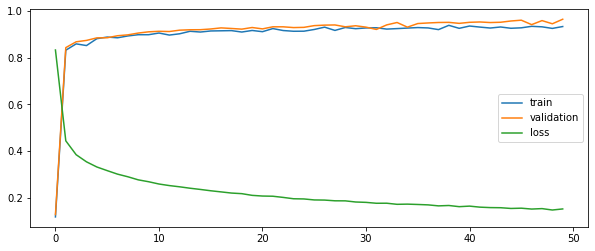

In [0]:
import matplotlib.pyplot as pl
from ipywidgets import interact, widgets
from matplotlib import animation

pl.figure(figsize=(10, 4))
pl.plot(acc_training, label='train')
pl.plot(acc_validation, label='validation')
pl.plot(logloss,label = 'loss')
pl.legend()


In [0]:
yhat_test = nn.predict(test_data)
yhat_test

array([5, 2, 1, ..., 8, 1, 5])

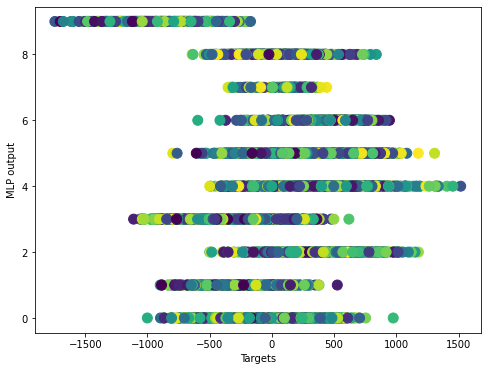

In [0]:
colors=np.random.rand(10000)
pl.figure(figsize=(8,6))
pl.scatter(test_data[:,2], yhat_test, s=100, c = colors)
pl.xlabel('Targets')
pl.ylabel('MLP output')
pl.show()